pip install xgboost

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import joblib
import warnings
warnings.filterwarnings('ignore')

In [104]:
# Data Loading and Preparation
file_path = 'AirQualityUCI.csv'
df = pd.read_csv(file_path, delimiter=';', decimal=',', parse_dates=[[0, 1]], na_values=-200)

In [105]:
# Drop unnecessary columns and handle missing values
df.drop(['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 
           'PT08.S4(NO2)', 'PT08.S5(O3)', 'Unnamed: 15', 'Unnamed: 16'], axis=1, inplace=True)
df.dropna(inplace=True)

# Convert `Date_Time` column to datetime format
df['Date_Time'] = pd.to_datetime(df['Date_Time'], format='%d/%m/%Y %H.%M.%S')

# Set `Date_Time` as the index
df.set_index('Date_Time', inplace=True)

In [106]:
df.head()

,CO(GT),NMHC(GT),C6H6(GT),NOx(GT),NO2(GT),T,RH,AH
Date_Time,,,,,,,,
2004-03-10 18:00:00,2.6,150.0,11.9,166.0,113.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,112.0,9.4,103.0,92.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,88.0,9.0,131.0,114.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,80.0,9.2,172.0,122.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,51.0,6.5,131.0,116.0,11.2,59.6,0.7888


In [107]:
# Data Preparation for Training

In [108]:
# Focusing on CO(GT) as the target variable for prediction
target_column = 'CO(GT)'

# Create time-based features
df['hour'] = df.index.hour
df['day'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

In [109]:
# Create lagged features 
for lag in [1, 3, 6, 12, 24]:
    df[f'{target_column}_lag_{lag}'] = df[target_column].shift(lag)

# Create rolling statistics
for window in [6, 12, 24]:
    df[f'{target_column}_rolling_mean_{window}'] = df[target_column].rolling(window=window).mean()
    df[f'{target_column}_rolling_std_{window}'] = df[target_column].rolling(window=window).std()

# Drop NaN values created by lagged features
df.dropna(inplace=True)

In [110]:
# Using 80% for training and 20% for testing
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

Training data shape: (642, 24)
Testing data shape: (161, 24)


In [111]:
# Model Development
# Dictionary to store model results
model_results = {}

In [112]:
# Prepare features and target variables
feature_columns = [col for col in df.columns if col != target_column and col not in ['Date', 'Time']]
X_train = train_data[feature_columns]
y_train = train_data[target_column]
X_test = test_data[feature_columns]
y_test = test_data[target_column]

In [113]:
X_train_baseline = train_data[[f'CO(GT)_lag_{lag}' for lag in [1, 3, 6, 12, 24]]]
X_test_baseline = test_data[[f'CO(GT)_lag_{lag}' for lag in [1, 3, 6, 12, 24]]]

# Linear Regression
baseline_lr_model = LinearRegression()
baseline_lr_model.fit(X_train_baseline, y_train)
baseline_lr_predictions = baseline_lr_model.predict(X_test_baseline)
baseline_lr_mae = mean_absolute_error(y_test, baseline_lr_predictions)
baseline_lr_rmse = np.sqrt(mean_squared_error(y_test, baseline_lr_predictions))
model_results['Baseline Linear Regression (Previous Values)'] = {'MAE': baseline_lr_mae, 'RMSE': baseline_lr_rmse}
print(f"Baseline Linear Regression (Previous Values) - MAE: {baseline_lr_mae:.4f}, RMSE: {baseline_lr_rmse:.4f}")

Baseline Linear Regression (Previous Values) - MAE: 0.6493, RMSE: 0.8868


In [114]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predictions))
model_results['Linear Regression'] = {'MAE': lr_mae, 'RMSE': lr_rmse}
print(f"Linear Regression - MAE: {lr_mae:.4f}, RMSE: {lr_rmse:.4f}")

Linear Regression - MAE: 0.1911, RMSE: 0.2356


In [115]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
model_results['Random Forest'] = {'MAE': rf_mae, 'RMSE': rf_rmse}
print(f"Random Forest - MAE: {rf_mae:.4f}, RMSE: {rf_rmse:.4f}")

Random Forest - MAE: 0.2200, RMSE: 0.2881


In [116]:
# XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
model_results['XGBoost'] = {'MAE': xgb_mae, 'RMSE': xgb_rmse}
print(f"XGBoost - MAE: {xgb_mae:.4f}, RMSE: {xgb_rmse:.4f}")

XGBoost - MAE: 0.2052, RMSE: 0.2657


In [117]:
# ARIMA
arima_train = train_data[target_column]
arima_test = test_data[target_column]

arima_model = ARIMA(arima_train, order=(1, 1, 1))
arima_model_fit = arima_model.fit()

# Forecast for the test period
arima_predictions = arima_model_fit.forecast(steps=len(arima_test))
arima_mae = mean_absolute_error(arima_test, arima_predictions)
arima_rmse = np.sqrt(mean_squared_error(arima_test, arima_predictions))
model_results['ARIMA'] = {'MAE': arima_mae, 'RMSE': arima_rmse}
print(f"ARIMA - MAE: {arima_mae:.4f}, RMSE: {arima_rmse:.4f}")

ARIMA - MAE: 3.0410, RMSE: 3.3057


In [118]:
# Model Comparison
results_df = pd.DataFrame(model_results).T
print("\nModel Comparison:")
print(results_df)


Model Comparison:
                                                   MAE      RMSE
Baseline Linear Regression (Previous Values)  0.649259  0.886833
Linear Regression                             0.191133  0.235631
Random Forest                                 0.220031  0.288133
XGBoost                                       0.205189  0.265656
ARIMA                                         3.041043  3.305664


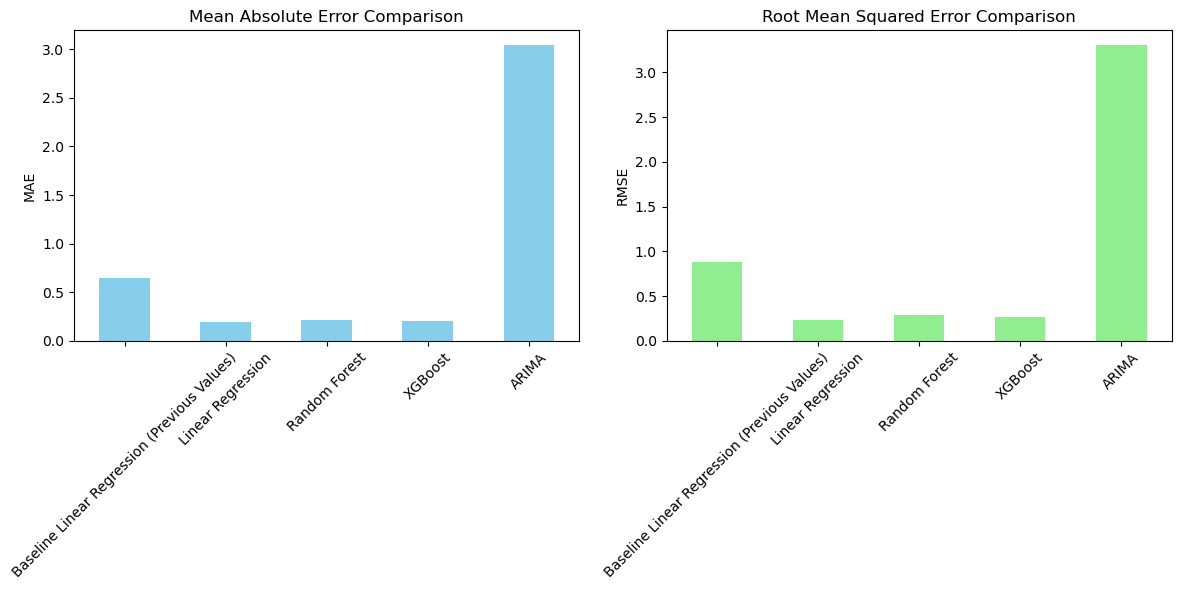

In [119]:
# Plot model comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
results_df['MAE'].plot(kind='bar', color='skyblue')
plt.title('Mean Absolute Error Comparison')
plt.ylabel('MAE')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
results_df['RMSE'].plot(kind='bar', color='lightgreen')
plt.title('Root Mean Squared Error Comparison')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

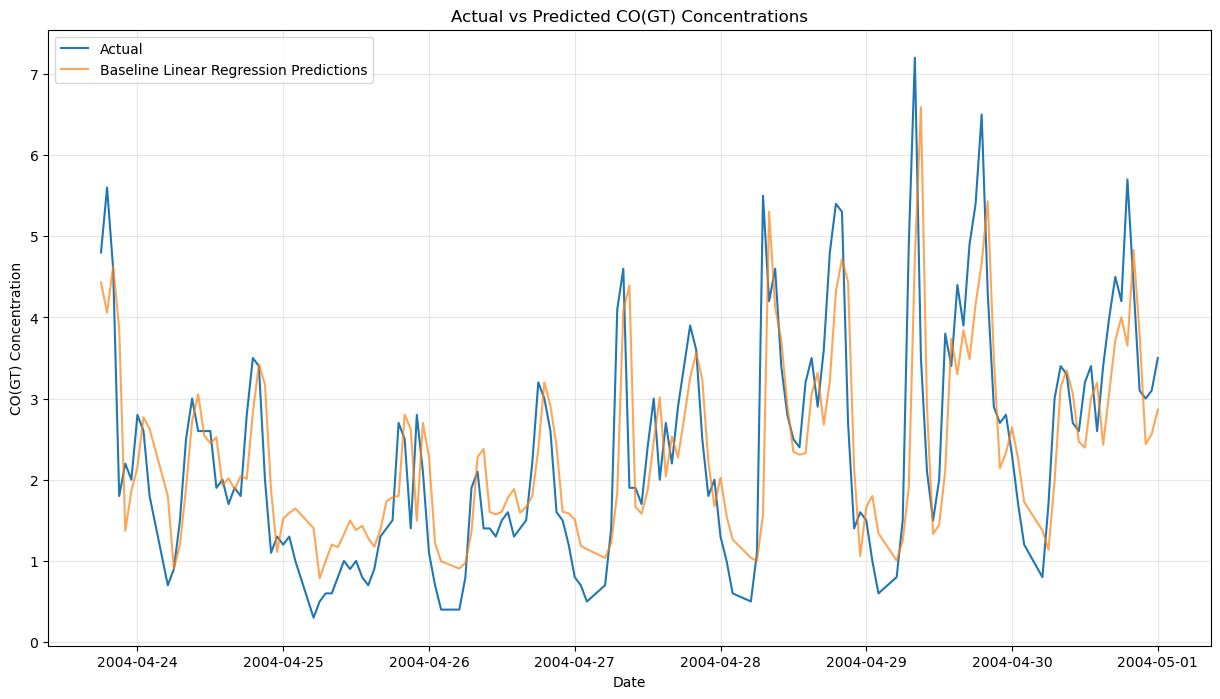

In [140]:
plt.figure(figsize=(15, 8))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, baseline_lr_predictions, label='Baseline Linear Regression Predictions', alpha=0.7)
plt.title(f'Actual vs Predicted {target_column} Concentrations')
plt.xlabel('Date')
plt.ylabel(f'{target_column} Concentration')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

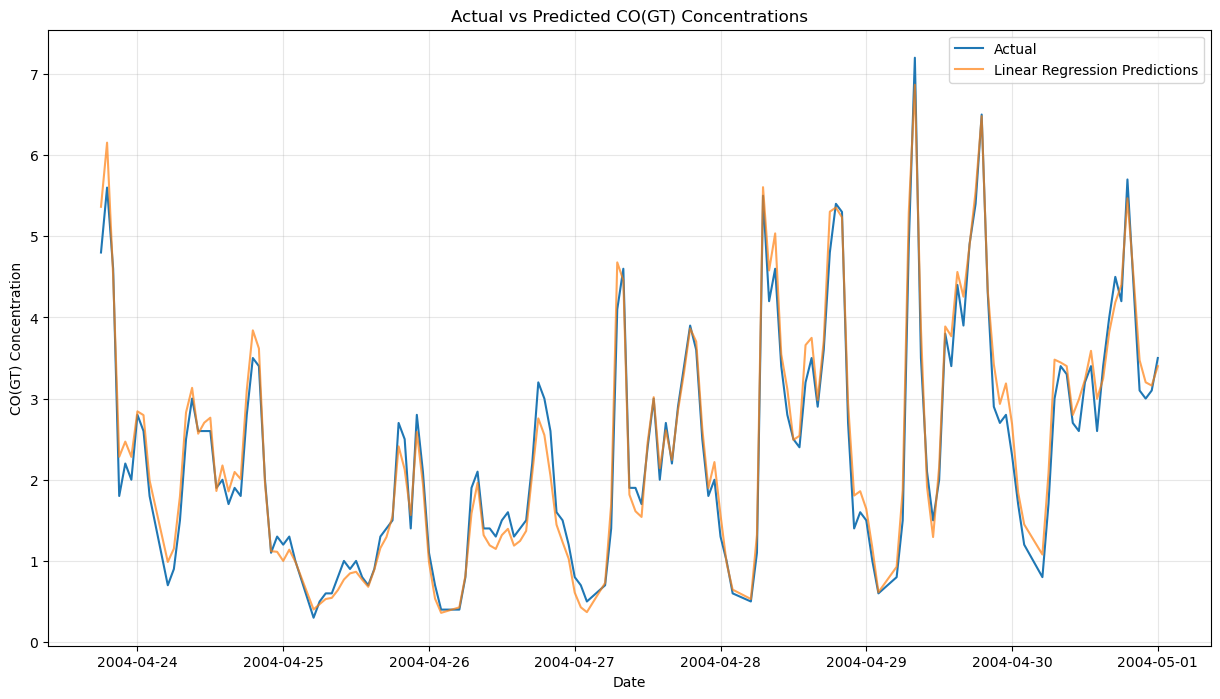

In [120]:
# Actual vs Predicted Visualization
plt.figure(figsize=(15, 8))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, lr_predictions, label='Linear Regression Predictions', alpha=0.7)
plt.title(f'Actual vs Predicted {target_column} Concentrations')
plt.xlabel('Date')
plt.ylabel(f'{target_column} Concentration')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

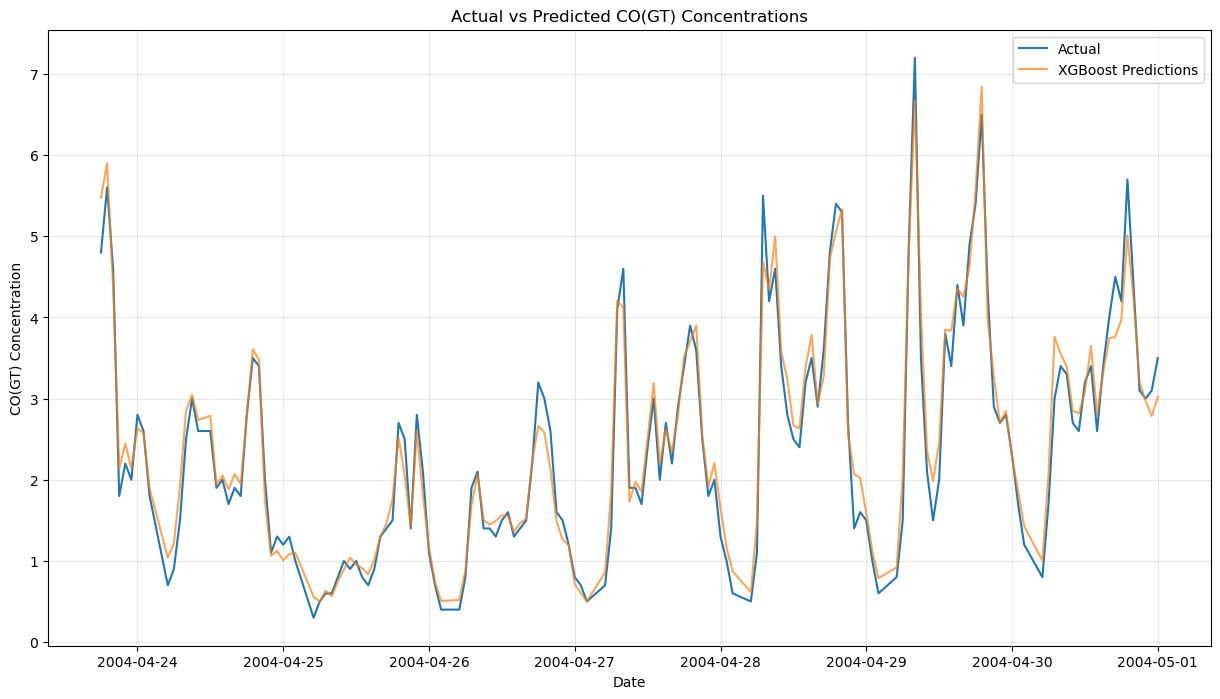

In [121]:
# Actual vs Predicted Visualization
plt.figure(figsize=(15, 8))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, xgb_predictions, label='XGBoost Predictions', alpha=0.7)
plt.title(f'Actual vs Predicted {target_column} Concentrations')
plt.xlabel('Date')
plt.ylabel(f'{target_column} Concentration')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

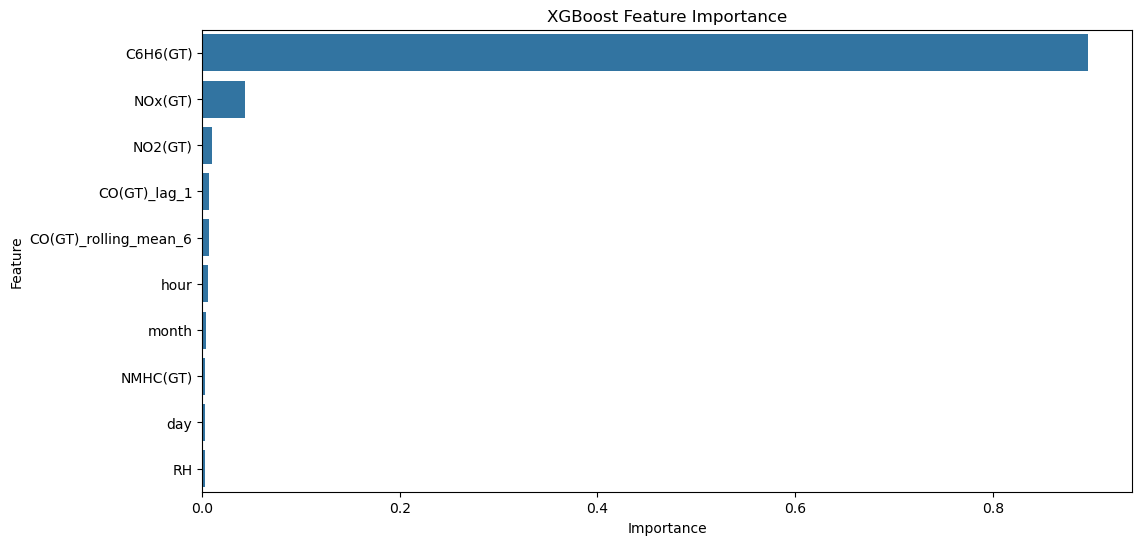

In [142]:
# XGBoost feature importance
xgb_feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_feature_importance.head(10))
plt.title('XGBoost Feature Importance')
plt.show()

In [144]:
# Save the best model for Kafka integration
joblib.dump(lr_model, 'air_quality_prediction_model.pkl')
# Save feature columns for future reference
pd.Series(feature_columns).to_csv('feature_columns.csv', index=False)

print("Model saved for Kafka integration.")

Model saved for Kafka integration.
